In [3]:
import os
from copy import deepcopy
import torch
from random import randint
from utils.loss_utils import l1_loss, ssim, l2_loss
from gaussian_renderer import render, network_gui
import sys
from scene import Scene, GaussianModel, DynamicScene
from utils.general_utils import safe_state
import uuid
from tqdm import tqdm
from utils.image_utils import psnr
from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams, FlowParams

import torch.nn.functional as F
from pytorch_msssim import ms_ssim
from lpips import LPIPS

from torch.utils.data import DataLoader
try:
    from torch.utils.tensorboard import SummaryWriter
    TENSORBOARD_FOUND = True
except ImportError:
    TENSORBOARD_FOUND = False
    
    
import taichi as ti
ti.init(arch=ti.cuda, offline_cache=False)

[Taichi] version 1.7.0, llvm 15.0.4, commit f9daa65b, linux, python 3.9.0


[I 11/27/23 12:51:43.412 2377373] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=cuda


In [2]:
name_prefix = "flame_steak"
dataset_path = "/home/loyot/workspace/SSD_1T/Datasets/NeRF/HyberNeRF/vrig_chicken/chicken"
config = "arguments/hypernerf/default.py"
name = f'{name_prefix}_fftpoly_60k'
checkpoint_path = f'output/{name_prefix}_fftpoly_60k/chkpnt60000.pth'

argss = '-s ' + f'{dataset_path}' + ' --model_path' + f' output/{name}/' + ' --config '+ f'{config}' + ' --start_checkpoint '+  checkpoint_path + ' --eval'

In [3]:
name_prefix = "flame_salmon_1"
dataset_path = "/home/loyot/workspace/SSD_1T/Datasets/NeRF/3d_vedio_datasets/flame_salmon_1/images_split/0"
config = "arguments/dynerf/default.py"
name = f'{name_prefix}_fftpoly_60k'
checkpoint_path = f'/home/loyot/workspace/code/gaussian-splatting/output/flame_salmon_1_fftpoly_60K/chkpnt60000.pth'

argss = '-s ' + f'{dataset_path}' + ' --model_path' + f' output/{name}/' + ' --config '+ f'{config}' + ' --start_checkpoint '+  checkpoint_path + ' --eval'

In [4]:
name_prefix = "flame_steak_fftpoly_60K_v2"
dataset_path = "/home/loyot/workspace/SSD_1T/Datasets/NeRF/3d_vedio_datasets/flame_steak/images_split/0"
config = "arguments/dynerf/default.py"
name = f'{name_prefix}_fftpoly_60k'
checkpoint_path = f'/home/loyot/workspace/code/gaussian-splatting/output/dynerf_new/flame_steak_fftpoly_60K_v2/chkpnt60000.pth'

argss = '-s ' + f'{dataset_path}' + ' --model_path' + f' output/{name}/' + ' --config '+ f'{config}' + ' --start_checkpoint '+  checkpoint_path + ' --eval'

In [5]:
# Set up command line argument parser
parser = ArgumentParser(description="Debug script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
ff = FlowParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", type=int, default=5000)
parser.add_argument("--save_iterations", type=int, default=5000)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", type=int, default=10000)
parser.add_argument("--start_checkpoint", type=str, default = None)
parser.add_argument("--configs", type=str, default = "")
parser.add_argument("--smc_file", type=str, default = None)
args = parser.parse_args(argss.split())
# args.save_iterations.append(args.iterations)

if args.configs:
    import mmcv
    from utils.params_utils import merge_hparams
    config = mmcv.Config.fromfile(args.configs)
    args = merge_hparams(args, config)
print("Optimizing " + args.model_path)

# Initialize system state (RNG)
safe_state(args.quiet)

Optimizing output/flame_steak_fftpoly_60K_v2_fftpoly_60k/
xyz_trajectory_type: fft_poly [27/11 12:51:56]
xyz_traj_feat_dim: 32 [27/11 12:51:56]
rot_trajectory_type: fft_poly [27/11 12:51:56]
rot_traj_feat_dim: 32 [27/11 12:51:56]
scale_trajectory_type: fft [27/11 12:51:56]
scale_traj_feat_dim: 20 [27/11 12:51:56]
opc_trajectory_type:  fft [27/11 12:51:56]
opc_traj_feat_dim: 20 [27/11 12:51:56]
feature_trajectory_type: fft [27/11 12:51:56]
feature_traj_feat_dim: 20 [27/11 12:51:56]
traj_init: <built-in method zeros of type object at 0x7f1f8e077a40> [27/11 12:51:56]
poly_base_factor: 1 [27/11 12:51:56]
Hz_base_factor: 0.5 [27/11 12:51:56]
Generating random point cloud (50000)... [27/11 12:51:56]
Number of points at initialisation :  53838 [27/11 12:51:57]


In [6]:
dataset=lp.extract(args)
opt=op.extract(args)
pipe=pp.extract(args)
flow_args=ff.extract(args)
testing_iterations=args.test_iterations
saving_iterations=args.save_iterations
checkpoint_iterations=args.checkpoint_iterations
checkpoint=args.start_checkpoint
debug_from=args.debug_from
smc_file=None

In [7]:
import os
os.path.exists(checkpoint)

True

In [8]:
first_iter = 0
# tb_writer = prepare_output_and_logger(dataset)
gaussians = GaussianModel(
    dataset.sh_degree,
    max_steps=opt.iterations+1,
    xyz_traj_feat_dim=flow_args.xyz_traj_feat_dim,
    xyz_trajectory_type=flow_args.xyz_trajectory_type,
    rot_traj_feat_dim=flow_args.rot_traj_feat_dim,
    rot_trajectory_type=flow_args.rot_trajectory_type,
    scale_traj_feat_dim=flow_args.scale_traj_feat_dim,
    scale_trajectory_type=flow_args.scale_trajectory_type,
    opc_traj_feat_dim=flow_args.opc_traj_feat_dim,
    opc_trajectory_type=flow_args.opc_trajectory_type,
    feature_traj_feat_dim=flow_args.feature_traj_feat_dim,
    feature_trajectory_type=flow_args.feature_trajectory_type,
    traj_init=flow_args.traj_init,
    poly_base_factor=flow_args.poly_base_factor,
    Hz_base_factor=flow_args.Hz_base_factor,
)
if pipe.real_dynamic:
    scene = DynamicScene(dataset, gaussians)
else:
    scene = Scene(
        dataset, 
        gaussians, 
        shuffle=pipe.dataset_shuffle, 
        load_img_factor=pipe.load_img_factor,
        smc_file=smc_file,
    )
    
gaussians.training_setup(opt, flow_args)
(model_params, first_iter) = torch.load(checkpoint)
gaussians.restore(model_params, opt, flow_args)

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

Reading frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 934.11it/s]


In [9]:

gaussians.oneupSHdegree()
gaussians.oneupSHdegree()
gaussians.oneupSHdegree()
gaussians.oneupSHdegree()

viewpoint_stack = None

# Pick a random Camera
if not viewpoint_stack:
    viewpoint_stack = scene.getTrainCameras()
    batch_size = opt.batch_size
    viewpoint_stack_loader = DataLoader(viewpoint_stack, batch_size=batch_size,shuffle=True,num_workers=32,collate_fn=list)
    loader = iter(viewpoint_stack_loader)
if opt.dataloader:
    try:
        viewpoint_cams = next(loader)
    except StopIteration:
        print("reset dataloader")
        batch_size = 1
        loader = iter(viewpoint_stack_loader)
else:
    idx = randint(0, len(viewpoint_stack)-1)
    viewpoint_cams = [viewpoint_stack[idx]]

In [10]:
viewpoint_cam = viewpoint_stack[0]

In [11]:
with torch.no_grad():
    accum_mid_xyz = torch.zeros_like(gaussians._xyz)
    for t_i in range(300):
        gaussians.timestamp = (t_i/gaussians.max_frames)
        accum_mid_xyz += torch.abs(gaussians.xyz_trajectory_func(
            gaussians._xyz_poly_params.contiguous(), 
            gaussians.timestamp, #* xyz_tfactor[0:1], 
            gaussians.traj_fit_degree
        ))

In [12]:
accum_mid_xyz_sum = accum_mid_xyz.mean(-1)

In [13]:
accum_mid_xyz_sum.mean()

tensor(63.6341, device='cuda:0')

In [14]:
viewcams = []
for i in range(19):
    viewcams.append(viewpoint_stack[i])
 # xp, xn, yp, yn, zp, zn

In [15]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import cv2
images = []
for t in tqdm.tqdm(range(300)):
    with torch.no_grad():
    # def run():   
        B = gaussians._xyz_poly_params.shape[0]
        move = torch.abs(gaussians._xyz_poly_params[:, :, 0].reshape(B, -1))
        move_sum = move.mean(-1) 

        # scale_mask = torch.abs(gaussians._scaling.reshape(B, -1)).mean(-1) < 4.0
        move_mask = move_sum > 0.01
        # rot_mask = torch.abs(gaussians._rot_poly_params.reshape(B, -1)).mean(-1) > 0.5
        # mask = scale_mask & move_mask & rot_mask
        # mask = accum_mid_xyz_sum > 23
        mask = torch.ones_like(move_mask).bool()
        # mask = move_mask
        gaussians.timestamp = (t/gaussians.max_frames)
        mid_xyz = gaussians.xyz_trajectory_func(
            gaussians._xyz_poly_params[mask].contiguous(), 
            gaussians.timestamp, #* xyz_tfactor[0:1], 
            gaussians.traj_fit_degree
        )

        mid_rot = gaussians.rot_trajectory_func(
            gaussians._rot_poly_params[mask].contiguous(), 
            gaussians.timestamp,# * xyz_tfactor[0:1], 
            gaussians.traj_fit_degree
        )
        mid_feature_dc = gaussians.feature_trajectory_func(
            gaussians._features_dc_poly_params[mask].contiguous(), 
            gaussians.timestamp, #* xyz_tfactor[0:1], 
            gaussians.traj_fit_degree
        ).reshape(-1, *gaussians._features_dc.shape[1:])

        gaussians.mid_xyz = mid_xyz
        gaussians.mid_rot = mid_rot
        gaussians.mid_feature_dc = mid_feature_dc
        gaussians._fwd_xyz = gaussians._xyz[mask] + gaussians.mid_xyz
        gaussians._fwd_rot = gaussians._rotation[mask] + gaussians.mid_rot
        gaussians._fwd_features_dc = gaussians._features_dc[mask] + gaussians.mid_feature_dc
        gaussians._fwd_feature = gaussians._features_rest[mask] 
        gaussians._fwd_scale = gaussians._scaling[mask] 
        gaussians._fwd_opc = gaussians._opacity[mask] 

        render_pkg = render(viewcams[0], gaussians, pipe, background, scaling_modifier=1.0, render_xyz=True)
        image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]
        img = torch.clamp(image, 0.0, 1.0)
        depth = render_pkg["depth"]
        opc = render_pkg["opacity"]
        render_xyz = render_pkg["render_xyz"]
        depth_normal = (depth - depth.min()) / (depth.max() - depth.min())
        np_depth_img = np.transpose((depth_normal.cpu().numpy() * 255).astype('uint8'), (1, 2, 0))
        # np_depth_img = cv2.applyColorMap(np_depth_img,cv2.COLORMAP_TURBO)
        depth_img = Image.fromarray(np_depth_img.repeat(3, 2))
        np_opc_img = np.transpose((opc.cpu().numpy() * 255).astype('uint8'), (1, 2, 0))
        opc_img = Image.fromarray(np_opc_img.repeat(3, 2))
        # Convert tensor to numpy array and transpose dimensions
        np_image = np.transpose((img.cpu().numpy() * 255).astype('uint8'), (1, 2, 0))
        pil_image = Image.fromarray(np_image)
        images.append(pil_image)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.94it/s]


In [18]:
gaussians._fwd_xyz.max()

tensor(38.8102, device='cuda:0')

In [19]:
gaussians._fwd_xyz.min()

tensor(-38.2652, device='cuda:0')

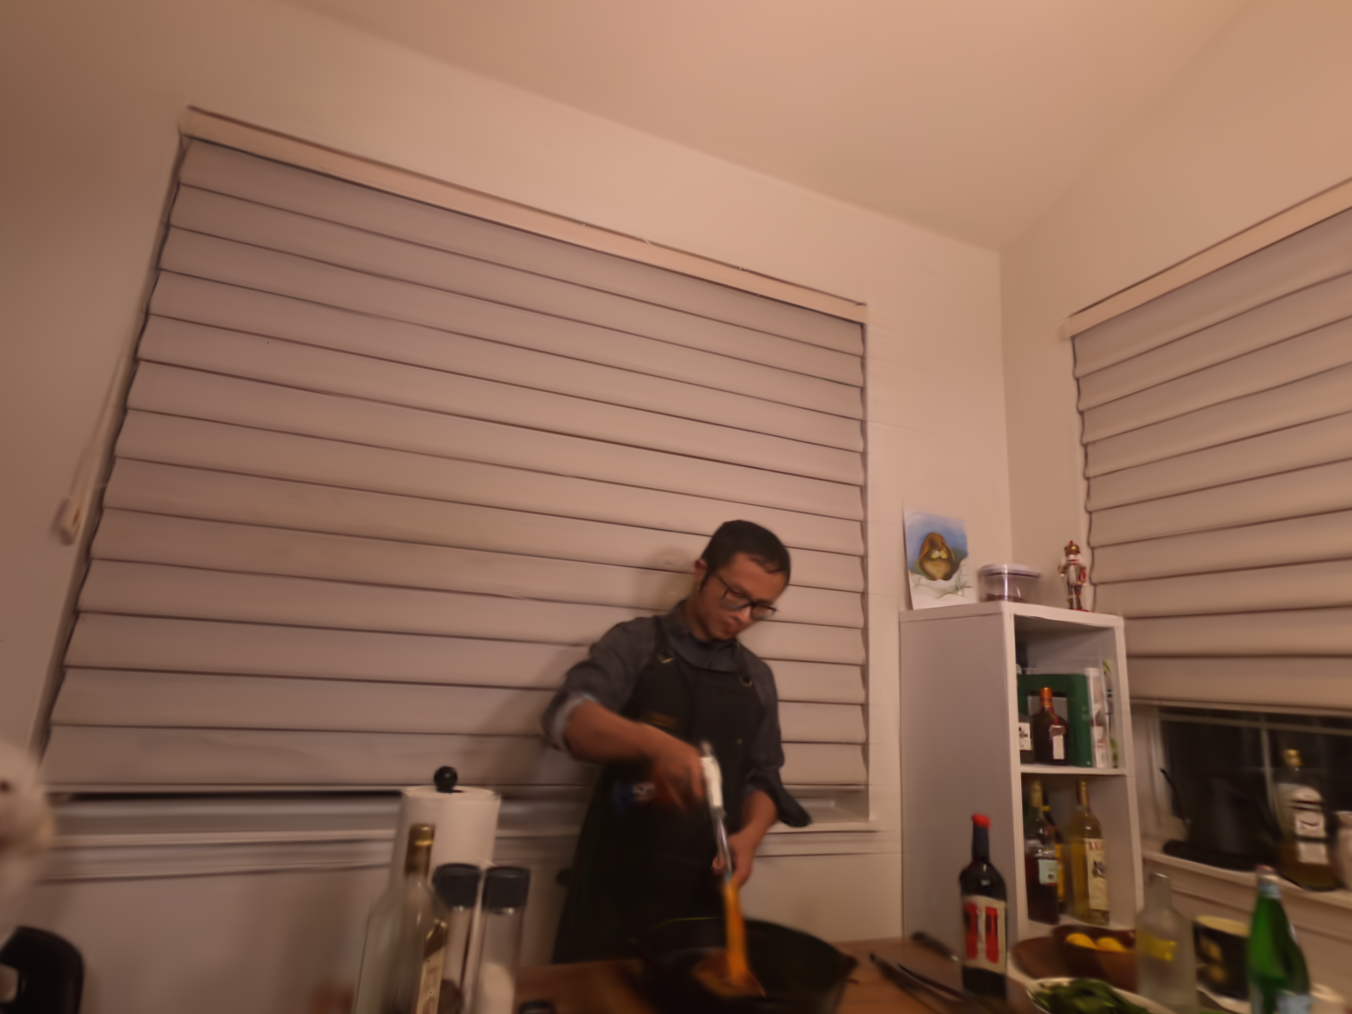

In [20]:
images[100]

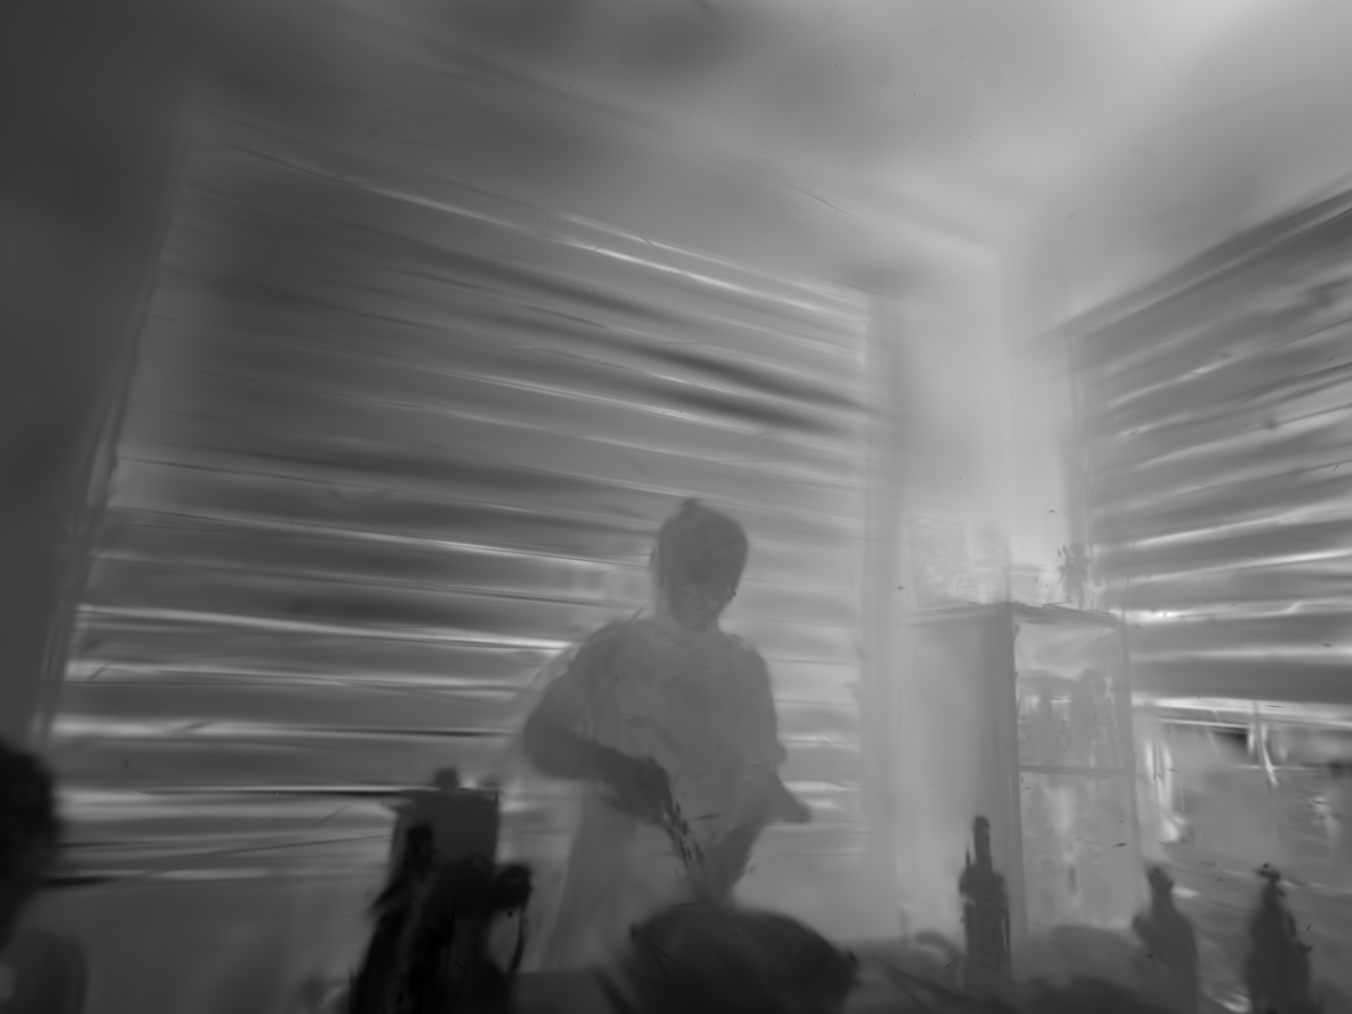

In [21]:
depth_img

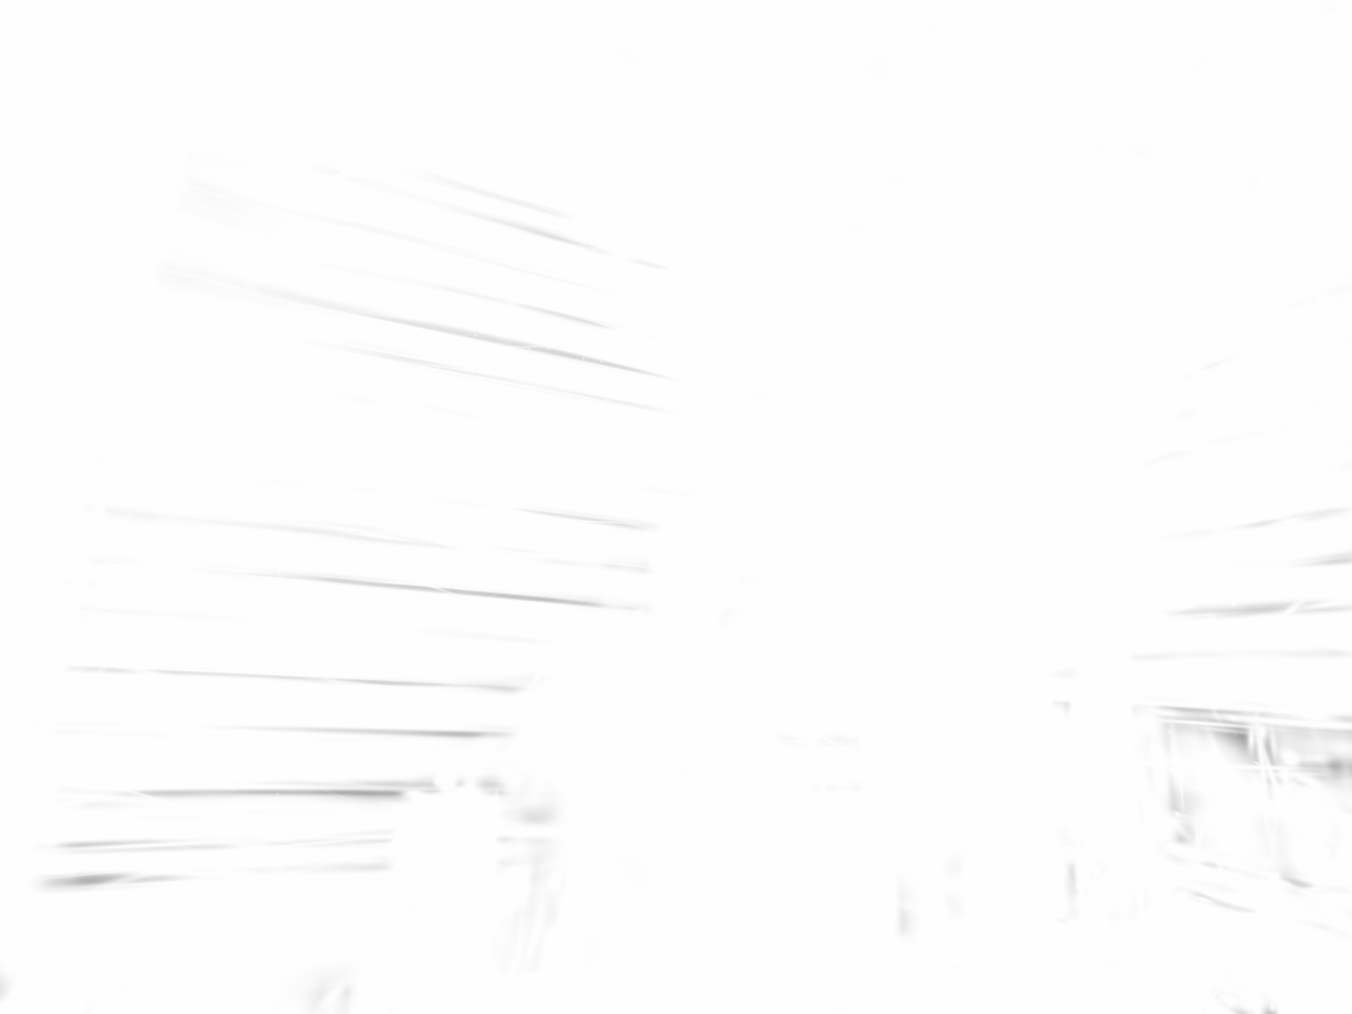

In [22]:
opc_img

In [38]:
k = np.array([
    [viewpoint_cams[0].FoVx, 0., viewpoint_cams[0].image_width//2],
    [0., viewpoint_cams[0].FoVy, viewpoint_cams[0].image_height//2],
    [0., 0., 1.],
])

In [39]:
def_pix = torch.tensor(
    np.stack(
        np.meshgrid(
            np.arange(viewpoint_cams[0].image_width) + 0.5, 
            np.arange(viewpoint_cams[0].image_height) + 0.5, 
            1
        ), -1
    ).reshape(-1, 3)).cuda().float()
pix_ones = torch.ones(viewpoint_cams[0].image_width * viewpoint_cams[0].image_height, 1).cuda().float()
def rgbd2pcd(im, depth, w2c, k, show_depth=False, project_to_cam_w_scale=None):
    d_near = 1.5
    d_far = 6
    invk = torch.inverse(torch.tensor(k).cuda().float())
    c2w = torch.inverse(torch.tensor(w2c).cuda().float())
    radial_depth = depth[0].reshape(-1)
    def_rays = (invk @ def_pix.T).T
    def_radial_rays = def_rays / torch.linalg.norm(def_rays, ord=2, dim=-1)[:, None]
    pts_cam = def_radial_rays * radial_depth[:, None]
    z_depth = pts_cam[:, 2]
    if project_to_cam_w_scale is not None:
        pts_cam = project_to_cam_w_scale * pts_cam / z_depth[:, None]
    pts4 = torch.concat((pts_cam, pix_ones), 1)
    pts = (c2w @ pts4.T).T[:, :3]
    if show_depth:
        cols = ((z_depth - d_near) / (d_far - d_near))[:, None].repeat(1, 3)
    else:
        cols = torch.permute(im, (1, 2, 0)).reshape(-1, 3)
    # pts = o3d.utility.Vector3dVector(pts.contiguous().double().cpu().numpy())
    # cols = o3d.utility.Vector3dVector(cols.contiguous().double().cpu().numpy())
    return pts, cols

In [22]:
pts, cols = rgbd2pcd(img, depth, viewpoint_cams[0].world_view_transform, k)

In [23]:
pts.shape

torch.Size([1370928, 3])

In [23]:
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [24]:
def f(t_input):
    im_t = images[t_input]
    newsize = (int(im_t.size[0]/2), int(im_t.size[1]/2))
    im_t = im_t.resize(newsize)
    display(im_t)

In [25]:
viewcams = []
for i in range(19):
    viewcams.append(viewpoint_stack[i])
 # xp, xn, yp, yn, zp, zn

In [26]:
xmax = gaussians._xyz[..., 0].max()
xmin = gaussians._xyz[..., 0].min()
ymax = gaussians._xyz[..., 1].max()
ymin = gaussians._xyz[..., 1].min()
zmax = gaussians._xyz[..., 2].max()
zmin = gaussians._xyz[..., 2].min()
f"xmax: {xmax}, xmin: {xmin}, ymax: {ymax}, ymin: {ymin}, zmax: {zmax}, zmin: {zmin}"

'xmax: 34.49127197265625, xmin: -35.641571044921875, ymax: 33.049278259277344, ymin: -32.58404541015625, zmax: 34.440574645996094, zmin: -32.494789123535156'

In [27]:
scale_mx = torch.abs(gaussians._scaling).max()
scale_mi = torch.abs(gaussians._scaling).min()

In [28]:
scale_mx

tensor(17.0191, device='cuda:0', grad_fn=<MaxBackward1>)

In [29]:
def f_render(idx, t_input, scale_m, thres_m, xp, xn, yp, yn, zp, zn, scale_thr_max, scale_thr_min):
    with torch.no_grad():
        viewcam_i=viewcams[idx]
        B = gaussians._xyz_poly_params.shape[0]
        move = torch.abs(gaussians._xyz_poly_params[:, :, 0].reshape(B, -1))
        move_sum = move.mean(-1) 
        
        xp_thers = xmax - xp
        xn_thers = xmin + xn
        yp_thers = ymax - yp
        yn_thers = ymin + yn
        zp_thers = zmax - zp
        zn_thers = zmin + zn
        space_mask = (
            gaussians._xyz[:, 0] < xp_thers
        ) & (
            gaussians._xyz[:, 0] > xn_thers
        ) & (
            gaussians._xyz[:, 1] < yp_thers
        ) & (
            gaussians._xyz[:, 1] > yn_thers
        ) & (
            gaussians._xyz[:, 2] < zp_thers
        ) & (
            gaussians._xyz[:, 2] > zn_thers
        )
        
        scale_mask = (torch.abs(gaussians._scaling).max(-1)[0] < scale_thr_max) & (torch.abs(gaussians._scaling).min(-1)[0] > scale_thr_min)

        # scale_mask = torch.abs(gaussians._scaling.reshape(B, -1)).mean(-1) < 4.0
        move_mask = move_sum > thres_m
        # rot_mask = torch.abs(gaussians._rot_poly_params.reshape(B, -1)).mean(-1) > 0.5
        # mask = scale_mask & move_mask & rot_mask
        # mask = (accum_mid_xyz_sum >= thres_m) & space_mask
        mask = torch.ones_like(move_mask).bool() & space_mask & scale_mask
        # mask = move_mask
        gaussians.timestamp = (t_input/gaussians.max_frames)
        mid_xyz = gaussians.xyz_trajectory_func(
            gaussians._xyz_poly_params[mask].contiguous(), 
            gaussians.timestamp, #* xyz_tfactor[0:1], 
            gaussians.traj_fit_degree
        )

        mid_rot = gaussians.rot_trajectory_func(
            gaussians._rot_poly_params[mask].contiguous(), 
            gaussians.timestamp,# * xyz_tfactor[0:1], 
            gaussians.traj_fit_degree
        )
        mid_feature_dc = gaussians.feature_trajectory_func(
            gaussians._features_dc_poly_params[mask].contiguous(), 
            gaussians.timestamp, #* xyz_tfactor[0:1], 
            gaussians.traj_fit_degree
        ).reshape(-1, *gaussians._features_dc.shape[1:])

        gaussians.mid_xyz = mid_xyz
        gaussians.mid_rot = mid_rot
        gaussians.mid_feature_dc = mid_feature_dc
        gaussians._fwd_xyz = gaussians._xyz[mask] + gaussians.mid_xyz
        gaussians._fwd_rot = gaussians._rotation[mask] + gaussians.mid_rot
        gaussians._fwd_features_dc = gaussians._features_dc[mask] + gaussians.mid_feature_dc
        gaussians._fwd_feature = gaussians._features_rest[mask]
        gaussians._fwd_scale = gaussians._scaling[mask]
        gaussians._fwd_opc = gaussians._opacity[mask]

        render_pkg = render(viewcam_i, gaussians, pipe, background, scaling_modifier=scale_m)
        image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]
        depth = render_pkg["depth"]
        pts, cols = rgbd2pcd(image, depth, viewpoint_cams[0].world_view_transform, k)
        img = torch.clamp(image, 0.0, 1.0)
        opc = render_pkg["opacity"]
        render_xyz = render_pkg["render_xyz"]
        depth_normal = (depth - depth.min()) / (depth.max() - depth.min())
        np_depth_img = np.transpose((depth_normal.cpu().numpy() * 255).astype('uint8'), (1, 2, 0))
        # np_depth_img = cv2.applyColorMap(np_depth_img,cv2.COLORMAP_TURBO)
        depth_img = Image.fromarray(np_depth_img.repeat(3, 2))
        np_opc_img = np.transpose((opc.cpu().numpy() * 255).astype('uint8'), (1, 2, 0))
        opc_img = Image.fromarray(np_opc_img.repeat(3, 2))
        # Convert tensor to numpy array and transpose dimensions
        np_image = np.transpose((img.cpu().numpy() * 255).astype('uint8'), (1, 2, 0))
        pil_image = Image.fromarray(np_image)
        newsize = (int(pil_image.size[0]/1), int(pil_image.size[1]/1))
        pil_image = pil_image.resize(newsize)
        return pil_image, pts, cols, gaussians._fwd_xyz, depth_img, opc_img

In [44]:
def f_render_w_t(idx, t_input, scale_m, thres_m, xp, xn, yp, yn, zp, zn, scale_thr_max, scale_thr_min, traj_id):
    with torch.no_grad():
        viewcam_i=viewcams[idx]
        B = gaussians._xyz_poly_params.shape[0]
        move = torch.abs(gaussians._xyz_poly_params[:, :, 0].reshape(B, -1))
        move_sum = move.mean(-1) 
        
        xp_thers = xmax - xp
        xn_thers = xmin + xn
        yp_thers = ymax - yp
        yn_thers = ymin + yn
        zp_thers = zmax - zp
        zn_thers = zmin + zn
        space_mask = (
            gaussians._xyz[:, 0] < xp_thers
        ) & (
            gaussians._xyz[:, 0] > xn_thers
        ) & (
            gaussians._xyz[:, 1] < yp_thers
        ) & (
            gaussians._xyz[:, 1] > yn_thers
        ) & (
            gaussians._xyz[:, 2] < zp_thers
        ) & (
            gaussians._xyz[:, 2] > zn_thers
        )
        
        scale_mask = (torch.abs(gaussians._scaling).max(-1)[0] < scale_thr_max) & (torch.abs(gaussians._scaling).min(-1)[0] > scale_thr_min)

        # scale_mask = torch.abs(gaussians._scaling.reshape(B, -1)).mean(-1) < 4.0
        move_mask = move_sum > thres_m
        # rot_mask = torch.abs(gaussians._rot_poly_params.reshape(B, -1)).mean(-1) > 0.5
        # mask = scale_mask & move_mask & rot_mask
        # mask = (accum_mid_xyz_sum >= thres_m) & space_mask
        mask = torch.ones_like(move_mask).bool() & space_mask & scale_mask
        # mask = move_mask
        gaussians.timestamp = (t_input/gaussians.max_frames)
        mid_xyz = gaussians.xyz_trajectory_func(
            gaussians._xyz_poly_params[mask][traj_id:traj_id+1].contiguous(), 
            gaussians.timestamp, #* xyz_tfactor[0:1], 
            gaussians.traj_fit_degree
        )

        mid_rot = gaussians.rot_trajectory_func(
            gaussians._rot_poly_params[mask][traj_id:traj_id+1].contiguous(), 
            gaussians.timestamp,# * xyz_tfactor[0:1], 
            gaussians.traj_fit_degree
        )
        mid_feature_dc = gaussians.feature_trajectory_func(
            gaussians._features_dc_poly_params[mask][traj_id:traj_id+1].contiguous(), 
            gaussians.timestamp, #* xyz_tfactor[0:1], 
            gaussians.traj_fit_degree
        ).reshape(-1, *gaussians._features_dc.shape[1:])

        gaussians.mid_xyz = mid_xyz
        gaussians.mid_rot = mid_rot
        gaussians.mid_feature_dc = mid_feature_dc
        gaussians._fwd_xyz = gaussians._xyz[mask][traj_id:traj_id+1] + gaussians.mid_xyz
        gaussians._fwd_rot = gaussians._rotation[mask][traj_id:traj_id+1] + gaussians.mid_rot
        gaussians._fwd_features_dc = gaussians._features_dc[mask][traj_id:traj_id+1] + gaussians.mid_feature_dc
        gaussians._fwd_feature = gaussians._features_rest[mask][traj_id:traj_id+1]
        gaussians._fwd_scale = gaussians._scaling[mask][traj_id:traj_id+1]
        gaussians._fwd_opc = gaussians._opacity[mask][traj_id:traj_id+1]

        render_pkg = render(viewcam_i, gaussians, pipe, background, scaling_modifier=scale_m)
        image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]
        depth = render_pkg["depth"]
        pts, cols = rgbd2pcd(image, depth, viewpoint_cams[0].world_view_transform, k)
        img = torch.clamp(image, 0.0, 1.0)
        # Convert tensor to numpy array and transpose dimensions
        np_image = np.transpose((img.cpu().numpy() * 255).astype('uint8'), (1, 2, 0))
        pil_image = Image.fromarray(np_image)
        newsize = (int(pil_image.size[0]/1), int(pil_image.size[1]/1))
        pil_image = pil_image.resize(newsize)
        return pil_image, pts, cols, gaussians._fwd_xyz
    

def real_render(idx, t_input, scale_m, thres_m, xp, xn, yp, yn, zp, zn, scale_thr_max, scale_thr_min):
    pil_image, pts, cols, _, depth_img, np_opc_img = f_render(idx, t_input, scale_m, thres_m, xp, xn, yp, yn, zp, zn, scale_thr_max, scale_thr_min)
    # pil_image_mask, pts, cols, _ = f_render(
    #     idx=0, 
    #     t_input=t_input, 
    #     scale_m=0.0, 
    #     thres_m=10, 
    #     xp=40.69, 
    #     xn=42.85, 
    #     yp=28.46, 
    #     yn=30.33, 
    #     zp=106.93, 
    #     zn=41.97, 
    #     scale_thr_max=24.66, 
    #     scale_thr_min=1.79,
    # )
    exp_image = np.array(pil_image)
    # exp_image.setflags(write=1)
    # all_mask = (np.array(pil_image_mask) > 0).all(-1)
    # exp_image[all_mask] = np.array([255, 0, 0])
    # exp_image[~all_mask] = np.array([0, 0, 0])
    # Image.fromarray(exp_image)
    display(Image.fromarray(exp_image))

def real_render_w_t(idx, t_input, scale_m, thres_m, xp, xn, yp, yn, zp, zn, scale_thr_max, scale_thr_min, traj):
    pil_image, pts, cols, _ = f_render(idx, t_input, scale_m, thres_m, xp, xn, yp, yn, zp, zn, scale_thr_max, scale_thr_min)
    pil_image_mask, pts, cols, _ = f_render_w_t(
        idx=0, 
        t_input=t_input, 
        scale_m=0.0, 
        thres_m=10, 
        xp=40.69, 
        xn=42.85, 
        yp=28.46, 
        yn=30.33, 
        zp=106.93, 
        zn=41.97, 
        scale_thr_max=24.66, 
        scale_thr_min=1.79,
        traj_id=traj,
    )
    exp_image = np.array(pil_image)
    exp_image.setflags(write=1)
    all_mask = (np.array(pil_image_mask) > 0).all(-1)
    exp_image[all_mask] = np.array([255, 0, 0])
    exp_image[~all_mask] = np.array([0, 0, 0])
    Image.fromarray(exp_image)
    display(Image.fromarray(exp_image))

In [76]:
image_i, pts_i, col_i, xyz_i = f_render(
    idx=0, 
    t_input=i, 
    scale_m=0.0, 
    thres_m=10, 
    xp=40.69, 
    xn=42.85, 
    yp=28.46, 
    yn=30.33, 
    zp=106.93, 
    zn=41.97, 
    scale_thr_max=24.66, 
    scale_thr_min=1.79,
)

In [77]:
col_mask = (col_i > 0).all(-1)

In [78]:
pts_i[col_mask]

tensor([[ 0.0074, -0.4065, -0.0041],
        [ 0.0035, -0.1621, -0.0015],
        [ 0.0065, -0.3585, -0.0036],
        ...,
        [-0.0188,  0.1012, -0.0015],
        [-0.2337,  1.2836, -0.0186],
        [-0.1038,  0.5809, -0.0080]], device='cuda:0')

In [79]:
xyz_i

tensor([[ 4.6820e+00, -1.7236e+00,  1.2887e+01],
        [ 2.7765e+00,  7.1731e-03,  1.5783e+01],
        [ 6.1142e+00,  3.3144e-01,  1.3750e+01],
        ...,
        [ 1.8722e+00,  4.2490e+00,  9.5019e+00],
        [ 1.7279e+00,  4.2366e+00,  9.5345e+00],
        [ 4.1326e+00,  4.6617e+00,  9.5575e+00]], device='cuda:0')

In [80]:
14037/ 4

3509.25

In [81]:
from PIL import ImageDraw
exp_image = np.array(images[0])
exp_image.setflags(write=1)
exp_img = Image.fromarray(exp_image)
exp_img_draw = ImageDraw.Draw(exp_img)
trajs = []
for j in tqdm.tqdm(range(0, 10000, 4)):
    traj_coords = []
    color = tuple(np.random.choice(range(255), size=4))
    for i in range(10):
        pil_image_i, pts, cols, _ = f_render_w_t(
            idx=0, 
            t_input=i, 
            scale_m=0.0, 
            thres_m=10, 
            xp=40.69, 
            xn=42.85, 
            yp=28.46, 
            yn=30.33, 
            zp=106.93, 
            zn=41.97, 
            scale_thr_max=24.66, 
            scale_thr_min=1.79,
            traj_id=j,
        )
        exp_image_i = np.array(pil_image_i)
        exp_image_i.setflags(write=1)
        all_mask_i = (exp_image_i > 0).all(-1)
        ind_x, ind_y = np.where(all_mask_i)
        if len(ind_x) > 0:
            traj_coords.append((ind_y[0], ind_x[0]))
    trajs.append(traj_coords)
    exp_img_draw.line(traj_coords, fill=color, width = 2) 

  1%|▉                                                                                                                                        | 18/2500 [00:06<14:57,  2.76it/s]


KeyboardInterrupt: 

In [82]:
exp_image = np.array(images[0])
exp_image.setflags(write=1)
exp_img = Image.fromarray(exp_image)
exp_img_draw = ImageDraw.Draw(exp_img)
for i in tqdm.tqdm(range(125)):
    color = tuple(np.random.choice(range(255), size=4))
    exp_img_draw.line(trajs[i][:10], fill=color, width = 2) 

 14%|███████████████████▍                                                                                                                   | 18/125 [00:00<00:00, 26269.13it/s]


IndexError: list index out of range

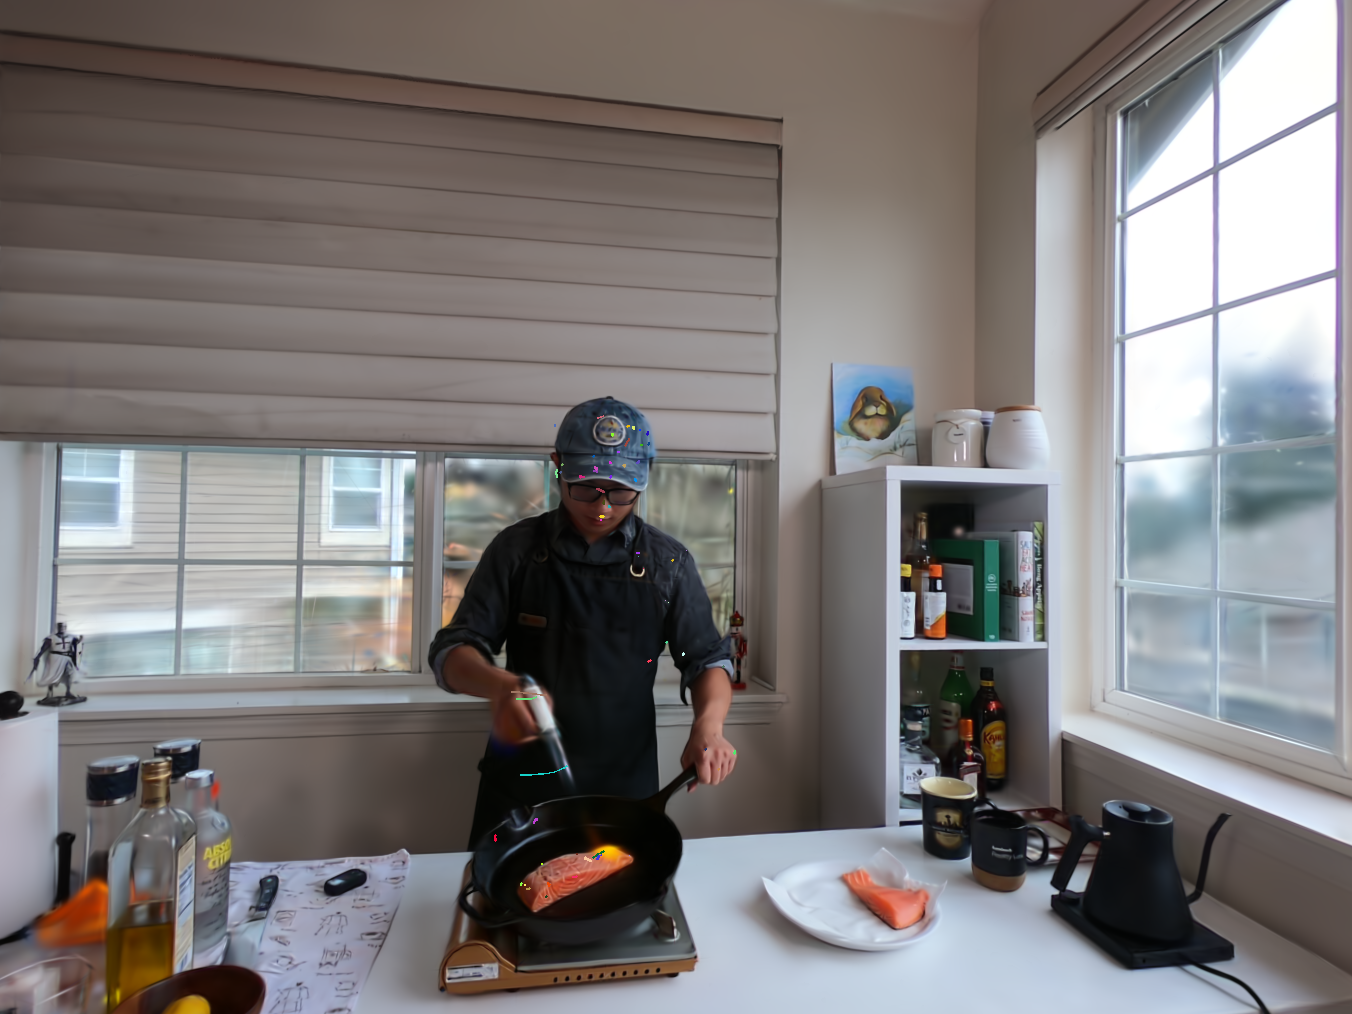

In [53]:
exp_img

In [83]:
from PIL import ImageDraw
exp_image = np.array(exp_image_i)
exp_image.setflags(write=1)
# all_mask = (exp_image > 0).all(-1)
# exp_image[all_mask_i] = np.array([255, 0, 0])
# exp_image[~all_mask_i] = np.array([0, 0, 0])
exp_img = Image.fromarray(exp_image)
exp_img_draw = ImageDraw.Draw(exp_img)
color = tuple(np.random.choice(range(255), size=4)) # random RGB colour
exp_img_draw.line(traj_coords, fill=color, width = 2) 

In [45]:
xlenght = torch.abs(xmax - xmin).item() / 2
ylenght = torch.abs(ymax - ymin).item() / 2
zlenght = torch.abs(zmax - zmin).item() / 2
w = interactive(
    real_render, 
    # real_render_w_t,
    idx=widgets.IntSlider(min=0, max=19, step=1, value=0), 
    t_input=widgets.IntSlider(min=0, max=299, step=1, value=10),
    scale_m=widgets.FloatSlider(min=0., max=1.0, step=0.001, value=1.0),
    thres_m=widgets.IntSlider(min=0., max=100., step=1, value=10),
    xp=widgets.FloatSlider(min=0., max=xlenght,step=0.01, value=40.69),
    xn=widgets.FloatSlider(min=0., max=xlenght, step=0.01, value=42.85),
    yp=widgets.FloatSlider(min=0., max=ylenght, step=0.01, value=28.46),
    yn=widgets.FloatSlider(min=0., max=ylenght, step=0.01, value=30.33),
    zp=widgets.FloatSlider(min=0., max=zmax, step=0.01, value=106.93),
    zn=widgets.FloatSlider(min=0., max=zmax, step=0.01, value=41.97),
    scale_thr_max=widgets.FloatSlider(min=0., max=scale_mx.item(), step=0.01, value=24.66),
    scale_thr_min=widgets.FloatSlider(min=0., max=scale_mx.item(), step=0.01, value=1.79),
    # traj=widgets.IntSlider(min=0., max=100, step=1, value=0),
)

In [42]:
# idx 7 t_input 24-53
for i in range(18):
    pil_image, pts, cols, _, depth_img, np_opc_img = f_render(
        i, 24, scale_m=1.0, thres_m=100, 
        xp=0, xn=0, yp=0, yn=0, zp=0, zn=0, 
        scale_thr_max=24.66, scale_thr_min=0)
    pil_image.save(f"flame_salmon_{i}_24.png")
    depth_img.save(f"depth_flame_salmon_{i}_24.png")
    np_opc_img.save(f"opc_flame_salmon_{i}_24.png")
    pil_image, pts, cols, _, depth_img, np_opc_img = f_render(
        i, 53, scale_m=1.0, thres_m=100, 
        xp=0, xn=0, yp=0, yn=0, zp=0, zn=0, 
        scale_thr_max=24.66, scale_thr_min=0)
    pil_image.save(f"flame_salmon_{i}_53.png")
    depth_img.save(f"depth_flame_salmon_{i}_53.png")
    np_opc_img.save(f"opc_flame_salmon_{i}_53.png")

In [48]:
for i in range(300):
    pil_image, pts, cols, _, depth_img, np_opc_img = f_render(
        0, i, scale_m=1.0, thres_m=100, 
        xp=0, xn=0, yp=0, yn=0, zp=0, zn=0, 
        scale_thr_max=24.66, scale_thr_min=0)
    pil_image.save(f"flame_steak/flame_steak_0_{i}.png")
    depth_img.save(f"flame_steak/depth_flame_steak_0_{i}.png")
    np_opc_img.save(f"flame_steak/opc_flame_steak_0_{i}.png")

In [46]:
w

interactive(children=(IntSlider(value=0, description='idx', max=19), IntSlider(value=10, description='t_input'…

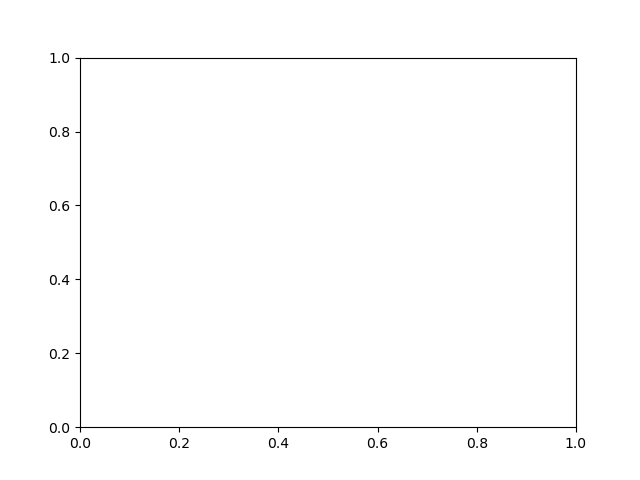

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


In [23]:
%matplotlib widget
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

In [25]:
import cv2
import numpy as np
from PIL import Image


# Convert PIL Images to NumPy arrays
frames = [np.array(img) for img in images]

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change 'mp4v' to other codecs
video = cv2.VideoWriter('output.mp4', fourcc, 30.0, (images[0].size[1], images[0].size[0]))  # Specify the desired FPS and frame size

# Write frames to the video
for frame in frames:
    video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR

# Release everything when job is finished
video.release()

In [24]:
images[0].size

(1352, 1014)